# Conformal Prediction

## Why use conformal prediction?

_Guess the following images:_

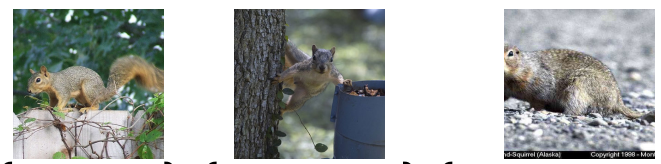


_Prediction set generated by conformal prediction for the images:_

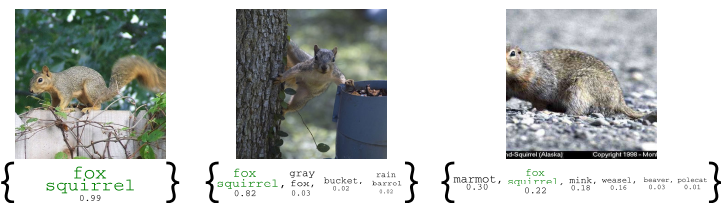


## Aim

Using conformal prediction we aim to generate rigorous, finite sample confidence intervals for any model and any dataset. Unlike a point prediction from neural network, here we will get a confidence interval in which desired output is guaranteed to be.

## Outline

1. Begin with a fitted predicted model which we call $\hat{f}$.
2. Create a predicted set (set of possible labels) for this model using a small amount of calibration data.


# Details of the method

---

## Given

1. A calibration dataset $\{(x_i,y_i)\}_{i=1}^n$ (This is the dataset that the model does not see during training).

2. A $model$ $\hat{\pi}(x) = P[Y=y|X=x]$

3. A $new$ $data$ $point$ $x_{n+1}$ to test the model


## Goal

Predict a set $\tau(X_{test})$ for the data point $X_{test}$ that is a subset of the label space $i.e.$ predict a set, $\tau(X_{test}) \subseteq y$. This set should contain the true class $Y_{test}$ and should be valid in the following sense:

$ 1 - \alpha \le P[Y_{test} \in \tau(X_{test})] \le 1 - \alpha +\frac{1}{n+1} $

here $\alpha$ is a user chosen rate in $\in [0,1]$, $y$ is the set of all labels & $n$ is the number of points in calibration dataset. The above mentioned property is called _Marginal Coverage_.


## Objective for the sets

1. Exact coverage

2. Small size

3. Size of the set should indicate the difficulty of the examples $i.e.$ Adaptivity


## General Method for Conformal Prediction

1. Identify a heuristic notion of uncertainity

2. Define a score function $S(x,y)$ based on the values in step 1. In general large values of $S$ corresponds to a bad fit between $x$ $\&$ $y$

3. Compute $\hat{q} : \frac{\lceil{(n+1)(1-\alpha)}\rceil}{n}$ quantile of $S(x,y)$ on calibration dataset

4. To obtain the prediction set: $\tau(x) = \{y:S(x,y) \le \hat{q} \}$


# Implementing classification model for MNIST dataset

In [2]:
import numpy as np
import os
import json
import random
import torch
import torchvision
import torch.nn as nn
import pandas as pd
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
from matplotlib.image import imread

# !pip install -U --no-cache-dir gdown --pre

In [3]:
n_epochs = 2
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [4]:
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        "dataset/",
        train=True,
        download=True,
        transform=torchvision.transforms.Compose(
            [
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((0.1307,), (0.3081,)),
            ]
        ),
    ),
    batch_size=batch_size_train,
    shuffle=True,
)

full_test = torchvision.datasets.MNIST(
    root="dataset/",
    train=False,
    download=True,
    transform=torchvision.transforms.Compose(
        [
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.1307,), (0.3081,)),
        ]
    ),
)


# Get the number of samples in the full dataset
num_samples = len(full_test)

# Split the dataset into two parts: test set and calibration set
test_size = num_samples // 2
calibration_size = num_samples - test_size
test_dataset, calibration_dataset = torch.utils.data.random_split(
    full_test, [test_size, calibration_size]
)

# Create the test and calibration loaders
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=5 * batch_size_test, shuffle=True
)
calibration_loader = torch.utils.data.DataLoader(
    calibration_dataset, batch_size=5 * batch_size_test, shuffle=True
)

In [5]:
target_values = []
for input_data, targets in train_loader:
    target_values.extend(targets.tolist())

target_values = np.array(target_values)

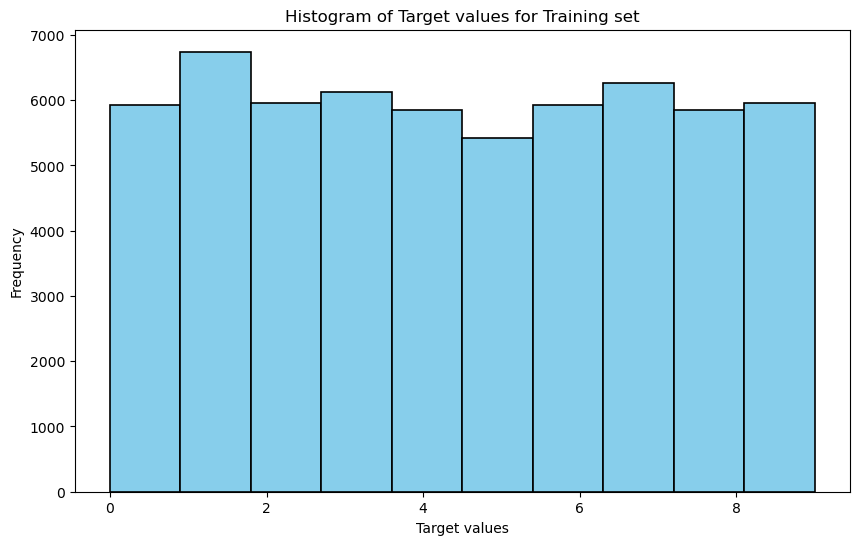

In [6]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(target_values, color="skyblue", edgecolor="black", linewidth=1.2)
ax.set_xlabel("Target values")
ax.set_ylabel("Frequency")
ax.set_title("Histogram of Target values for Training set")
plt.show()


0


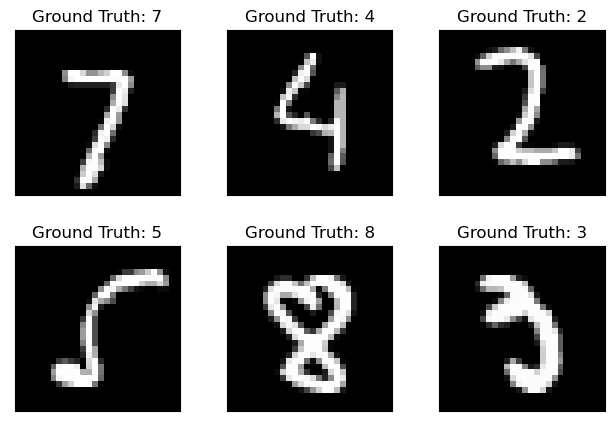

In [7]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(batch_idx)

fig = plt.figure()
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap="gray", interpolation="none")
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])


In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.softmax(x, dim=1)


In [9]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)


In [10]:
train_losses = []
train_counter = []

test_losses = []
test_counter = []

In [11]:
criterion = nn.CrossEntropyLoss()

In [12]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item(),
                )
            )

            # train_losses.append(loss.item())
            # train_counter.append(
            #   (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), "results/model.pth")
            torch.save(optimizer.state_dict(), "results/optimizer.pth")
    train_losses.append(loss.item())
    train_counter.append(epoch)

In [13]:
def test(epoch):
    network.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            test_loss += F.nll_loss(output, target, reduction="sum").item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    test_counter.append(epoch)
    print(
        "\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )

In [14]:
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test(epoch)


Train Epoch: 1 [0/60000 (0%)]	Loss: -0.096270
Train Epoch: 1 [640/60000 (1%)]	Loss: -0.101968
Train Epoch: 1 [1280/60000 (2%)]	Loss: -0.094875
Train Epoch: 1 [1920/60000 (3%)]	Loss: -0.096943
Train Epoch: 1 [2560/60000 (4%)]	Loss: -0.100370
Train Epoch: 1 [3200/60000 (5%)]	Loss: -0.106169
Train Epoch: 1 [3840/60000 (6%)]	Loss: -0.095606
Train Epoch: 1 [4480/60000 (7%)]	Loss: -0.100021
Train Epoch: 1 [5120/60000 (9%)]	Loss: -0.097964
Train Epoch: 1 [5760/60000 (10%)]	Loss: -0.105364
Train Epoch: 1 [6400/60000 (11%)]	Loss: -0.099801
Train Epoch: 1 [7040/60000 (12%)]	Loss: -0.104224
Train Epoch: 1 [7680/60000 (13%)]	Loss: -0.102671
Train Epoch: 1 [8320/60000 (14%)]	Loss: -0.102677
Train Epoch: 1 [8960/60000 (15%)]	Loss: -0.098862
Train Epoch: 1 [9600/60000 (16%)]	Loss: -0.104594
Train Epoch: 1 [10240/60000 (17%)]	Loss: -0.107961
Train Epoch: 1 [10880/60000 (18%)]	Loss: -0.101030
Train Epoch: 1 [11520/60000 (19%)]	Loss: -0.106397
Train Epoch: 1 [12160/60000 (20%)]	Loss: -0.105689
Train Epo

In [15]:
len(test_counter), len(test_losses)


(2, 2)

Text(0, 0.5, 'Loss')

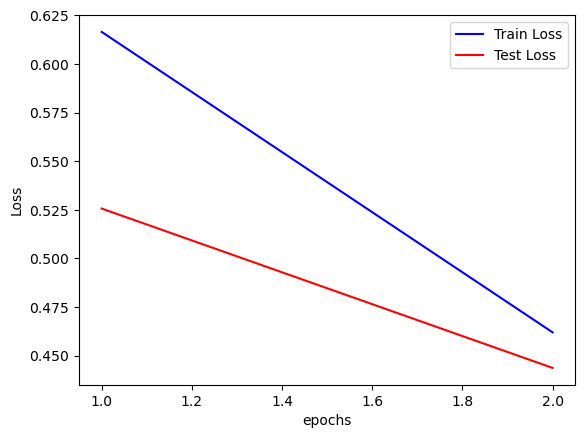

In [16]:
fig = plt.figure()
plt.plot(train_counter, np.exp(train_losses), color="blue")
plt.plot(test_counter, np.exp(test_losses), color="red")
plt.legend(["Train Loss", "Test Loss"], loc="upper right")
plt.xlabel("epochs")
plt.ylabel("Loss")


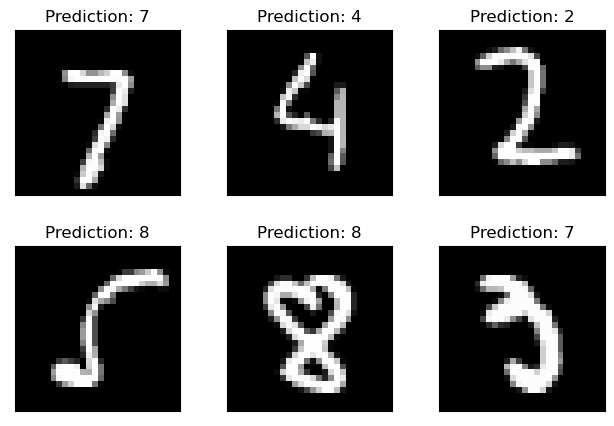

In [17]:
with torch.no_grad():
    output = network(example_data)

fig = plt.figure()
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap="gray", interpolation="none")
    plt.title("Prediction: {}".format(output.data.max(1, keepdim=True)[1][i].item()))
    plt.xticks([])
    plt.yticks([])


In [18]:
calib_prediction_results = np.array([])
calib_target_results = np.array([])

network.eval()
for data, target in calibration_loader:
    output = network(data)
    calib_prediction_results = output.data
    calib_target_results = target.data


In [19]:
test_prediction_results = np.array([])
test_target_results = np.array([])
test_images = np.array([])


network.eval()
for data, target in test_loader:
    output = network(data)
    test_images = data
    test_prediction_results = output.data
    test_target_results = target.data


## *Now Lets' implement conformal Prediction*

**A simpler version of the conformal prediction**

1. Compute $\hat{q} : \alpha$ quantile of $S(x,y)$ on calibration dataset where $S(x,y)$ is the score function correspoding to the true label

2. To obtain the prediction set: $\tau(x) = \{y:S(x,y) \ge \hat{q} \}$


In [20]:
calib_target_results = np.array(calib_target_results)
calib_prediction_results = np.array(calib_prediction_results)
test_prediction_results = np.array(test_prediction_results)
test_target_results = np.array(test_target_results)

calib_prediction_results.shape, calib_target_results.shape, test_prediction_results.shape, test_target_results.shape

((5000, 10), (5000,), (5000, 10), (5000,))

In [21]:
calib_df = pd.DataFrame(calib_prediction_results)
calib_df["Max"] = calib_df.max(axis=1)
calib_df["Max_idx"] = calib_df.idxmax(axis=1)
calib_df["True_idx"] = calib_target_results
calib_df


0             1             2             3             4  \
0     7.672552e-08  5.311417e-07  1.562821e-04  3.211690e-09  4.822823e-04   
1     7.041307e-08  1.779545e-07  6.658971e-06  4.084817e-07  6.008969e-08   
2     1.891271e-06  7.539936e-07  8.252732e-06  7.875642e-05  6.665982e-01   
3     3.600329e-08  4.196039e-09  4.928238e-06  3.145105e-09  9.909703e-01   
4     8.007726e-06  8.686094e-05  1.262506e-04  9.905047e-01  2.181237e-07   
...            ...           ...           ...           ...           ...   
4995  3.017699e-06  8.860756e-05  3.417503e-04  9.827271e-01  5.802370e-05   
4996  5.440750e-13  9.999996e-01  7.675386e-08  5.033297e-11  2.031701e-11   
4997  5.372684e-09  3.440873e-09  1.484947e-07  9.999758e-01  2.131953e-12   
4998  1.966202e-07  6.421658e-07  5.014269e-05  2.109797e-09  2.172950e-05   
4999  2.777072e-14  1.000000e+00  1.977435e-08  3.481474e-11  2.748897e-12   

                 5             6             7             8             9  \
0     2.262360e-06  9.993560e-01  3.220139e-11  1.609646e-06  9.680530e-07   
1     1.122653e-08  1.417746e-04  1.310595e-09  9.998498e-01  9.002325e-07   
2     2.489255e-06  7.079141e-04  4.619782e-05  3.568919e-02  2.968663e-01   
3     3.594812e-08  2.783901e-05  7.394720e-06  8.526304e-07  8.988610e-03   
4     3.404921e-07  8.625836e-06  2.125504e-06  9.200612e-03  6.224329e-05   
...            ...           ...           ...           ...           ...   
4995  1.595727e-06  2.064353e-04  2.161075e-06  1.435820e-02  2.213240e-03   
4996  4.493560e-11  7.547337e-10  3.736634e-08  2.838881e-07  3.246134e-12   
4997  4.374669e-11  2.115596e-12  2.734103e-06  2.123476e-05  9.234377e-08   
4998  5.110368e-07  9.999149e-01  3.196222e-10  3.617991e-06  8.205562e-06   
4999  9.301366e-12  5.802548e-11  3.565957e-08  2.786610e-08  1.873916e-12   

           Max  Max_idx  True_idx  
0     0.999356        6         6  
1     0.999850        8         8  
2     0.666598        4         5  
3     0.990970        4         4  
4     0.990505        3         3  
...        ...      ...       ...  
4995  0.982727        3         3  
4996  1.000000        1         1  
4997  0.999976        3         3  
4998  0.999915        6         4  
4999  1.000000        1         1  

[5000 rows x 13 columns]

In [22]:
test_df = pd.DataFrame(test_prediction_results)
test_df["Max"] = test_df.max(axis=1)
test_df["Max_idx"] = test_df.idxmax(axis=1)
test_df["True_idx"] = test_target_results
test_df


0             1             2             3             4  \
0     1.507169e-09  6.793355e-10  9.392306e-10  3.272889e-09  4.279739e-09   
1     1.528662e-08  4.265159e-12  3.008223e-05  9.999698e-01  1.717640e-15   
2     1.440134e-10  3.157558e-06  2.407116e-05  5.108404e-11  5.610714e-07   
3     6.468001e-12  9.999986e-01  3.110969e-07  3.365797e-09  3.275069e-11   
4     8.815193e-05  6.341890e-03  8.312734e-04  1.951014e-04  1.125594e-02   
...            ...           ...           ...           ...           ...   
4995  2.418953e-08  7.203251e-08  1.530548e-07  2.897828e-06  5.851566e-07   
4996  4.415281e-09  1.504091e-08  2.217878e-06  9.999076e-01  1.170547e-09   
4997  1.863301e-18  3.640452e-17  5.301770e-13  5.253428e-15  9.999909e-01   
4998  6.859559e-17  7.214033e-16  3.279532e-11  1.938939e-14  9.999964e-01   
4999  2.643393e-01  7.046102e-07  1.252546e-02  5.733218e-01  1.109647e-07   

                 5             6             7             8             9  \
0     1.000421e-10  7.060916e-13  9.973305e-01  3.673427e-07  2.669133e-03   
1     2.861857e-14  1.901743e-12  4.749006e-13  8.433129e-08  6.817440e-14   
2     1.101829e-08  9.999588e-01  4.209422e-15  1.334558e-05  3.933881e-10   
3     3.477734e-10  1.458348e-08  3.999051e-08  1.144535e-06  1.596769e-10   
4     2.372148e-04  7.425601e-03  1.311864e-03  1.279543e-02  9.595175e-01   
...            ...           ...           ...           ...           ...   
4995  6.657368e-09  3.703725e-08  6.012499e-05  9.920814e-01  7.854681e-03   
4996  1.767450e-10  1.133458e-08  1.103373e-09  8.993938e-05  2.646218e-07   
4997  7.949940e-15  1.362663e-11  6.954227e-13  6.574446e-12  9.051804e-06   
4998  1.438514e-13  1.612270e-10  2.956339e-12  7.959585e-12  3.579523e-06   
4999  3.844558e-07  2.375773e-02  1.729390e-07  1.260542e-01  1.263923e-07   

           Max  Max_idx  True_idx  
0     0.997331        7         7  
1     0.999970        3         3  
2     0.999959        6         6  
3     0.999999        1         1  
4     0.959518        9         4  
...        ...      ...       ...  
4995  0.992081        8         8  
4996  0.999908        3         3  
4997  0.999991        4         4  
4998  0.999996        4         4  
4999  0.573322        3         5  

[5000 rows x 13 columns]

## *Intuitive understanding*

In [23]:
stds_cal = np.std(calib_prediction_results, axis=1)
min_std_indices_cal = np.argsort(stds_cal)

_Sorting based on std deviation in the rows_


In [24]:
calib_df_std = calib_df.loc[min_std_indices_cal]
calib_df_std

0             1             2             3             4  \
4792  2.204627e-01  1.263805e-02  1.064651e-01  2.497595e-02  3.831481e-02   
3635  3.720535e-03  3.984575e-02  6.415164e-02  8.764555e-02  3.574266e-01   
1115  1.880663e-02  2.226060e-01  8.889224e-02  6.196426e-02  1.060972e-02   
1031  1.033852e-01  5.177050e-02  7.211524e-02  1.307259e-01  8.214290e-03   
1778  7.243351e-02  5.959544e-05  1.995622e-01  1.425000e-05  2.422987e-01   
...            ...           ...           ...           ...           ...   
2909  1.735541e-15  2.001958e-12  8.669379e-16  1.821178e-15  2.716592e-15   
2914  1.000000e+00  5.918221e-19  1.986233e-10  1.237661e-14  4.863426e-19   
2920  1.139901e-11  6.290391e-12  4.389559e-08  1.000000e+00  4.736745e-17   
2847  2.374335e-11  5.410563e-10  1.000000e+00  6.474658e-10  3.318972e-12   
4999  2.777072e-14  1.000000e+00  1.977435e-08  3.481474e-11  2.748897e-12   

                 5             6             7             8             9  \
4792  1.915999e-02  2.428759e-01  4.884591e-02  2.138946e-01  7.236703e-02   
3635  1.044143e-02  2.420991e-02  2.146130e-01  4.631169e-02  1.516339e-01   
1115  5.382521e-03  2.736638e-01  7.305532e-03  2.858033e-01  2.496605e-02   
1031  5.626875e-03  2.568235e-01  5.283331e-03  3.498454e-01  1.620973e-02   
1778  4.558027e-04  1.450675e-01  8.497129e-03  4.330557e-04  3.311783e-01   
...            ...           ...           ...           ...           ...   
2909  2.300831e-16  2.615356e-20  1.000000e+00  8.539057e-13  3.396687e-09   
2914  3.770102e-16  1.504733e-11  7.523226e-09  1.627343e-10  1.057123e-13   
2920  5.172185e-15  1.662083e-15  2.492923e-11  5.069354e-10  1.366577e-12   
2847  1.285993e-12  1.194038e-08  1.259493e-15  1.686373e-10  9.267352e-15   
4999  9.301366e-12  5.802548e-11  3.565957e-08  2.786610e-08  1.873916e-12   

           Max  Max_idx  True_idx  
4792  0.242876        6         5  
3635  0.357427        4         6  
1115  0.285803        8         5  
1031  0.349845        8         5  
1778  0.331178        9         2  
...        ...      ...       ...  
2909  1.000000        7         7  
2914  1.000000        0         0  
2920  1.000000        3         3  
2847  1.000000        2         2  
4999  1.000000        1         1  

[5000 rows x 13 columns]

In [25]:
y1 = calib_prediction_results[min_std_indices_cal[0]]
y2 = calib_prediction_results[min_std_indices_cal[1]]
y3 = calib_prediction_results[min_std_indices_cal[2]]
y4 = calib_prediction_results[4500]

x = np.arange(10)

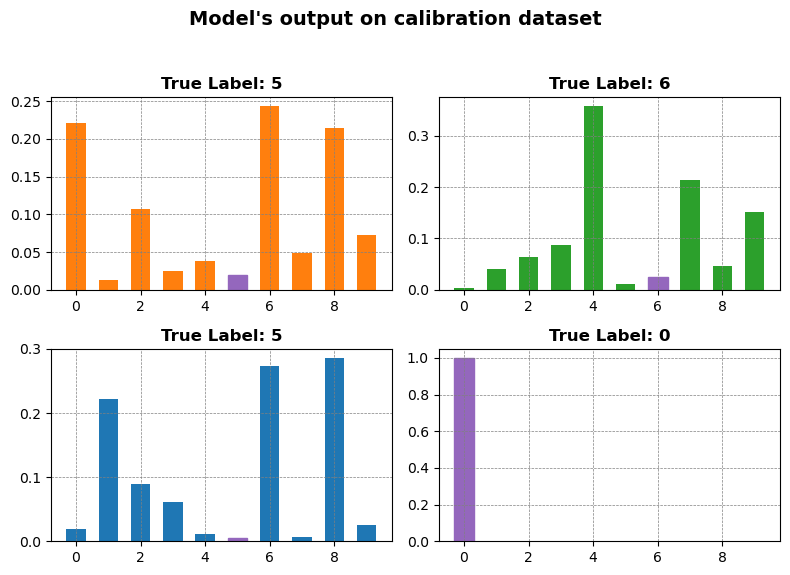

In [26]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6))

# Add bar plots to the subplots
bars1 = axs[0, 0].bar(x, y1, color="#ff7f0e", width=0.6)
axs[0, 0].set_title(
    f"True Label: {calib_target_results[min_std_indices_cal[0]]}",
    fontsize=12,
    fontweight="bold",
)
bars2 = axs[0, 1].bar(x, y2, color="#2ca02c", width=0.6)
axs[0, 1].set_title(
    f"True Label: {calib_target_results[min_std_indices_cal[1]]}",
    fontsize=12,
    fontweight="bold",
)
bars3 = axs[1, 0].bar(x, y3, color="#1f77b4", width=0.6)
axs[1, 0].set_title(
    f"True Label: {calib_target_results[min_std_indices_cal[2]]}",
    fontsize=12,
    fontweight="bold",
)
bars4 = axs[1, 1].bar(x, y4, color="#d62728", width=0.6)
axs[1, 1].set_title(
    f"True Label: {calib_target_results[4500]}", fontsize=12, fontweight="bold"
)

# Add labels and title to the figure
fig.suptitle("Model's output on calibration dataset", fontsize=14, fontweight="bold")

for ax in axs.flat:
    ax.grid(color="gray", linestyle="--", linewidth=0.5)

# Fine-tune the subplot layout
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

bars1[calib_target_results[min_std_indices_cal[0]]].set_color("#9467bd")
bars2[calib_target_results[min_std_indices_cal[1]]].set_color("#9467bd")
bars3[calib_target_results[min_std_indices_cal[2]]].set_color("#9467bd")
bars4[calib_target_results[4500]].set_color("#9467bd")

In [53]:
calib_true = calib_prediction_results[
    np.arange(calib_prediction_results.shape[0]), calib_target_results
]


_From the above plot it is evident that most of the softmax outputs corresponding to the true label are either close to 1 or close to 0. Thus, once we find out the value corresponding to the threshold of the 0 peak in the plot. Any quantile value just above this will quickly go near the next peak as there is no distribution mass for the rest of the softmax outputs._


In [54]:
## Quantile value that we use to predict the prediction set
qhat_intuit = np.quantile(calib_true, 0.15)  ## taking 15% quantile
qhat_intuit


0.17026243805885327

_This leads to the fact that 85% of examples have their true class softmax score above $\hat{q}_{intuit}$\_


_Sorting the test dataset according to std_


In [30]:
stds_test = np.std(test_prediction_results, axis=1)
min_std_indices_test = np.argsort(stds_test)

In [31]:
test_df_std = test_df.loc[min_std_indices_test]
test_df_std

0             1             2             3             4  \
1646  9.070086e-06  7.102170e-02  1.074573e-01  2.019677e-01  2.011996e-01   
1184  4.843292e-08  1.841913e-01  5.504493e-02  1.019774e-01  1.562013e-01   
3654  4.213768e-04  7.209036e-02  1.887893e-02  1.189776e-02  3.334404e-01   
3019  2.256842e-01  2.321515e-07  2.911193e-01  2.409384e-01  1.869016e-11   
4896  1.610583e-01  4.679085e-05  8.821968e-04  1.386619e-01  1.308930e-03   
...            ...           ...           ...           ...           ...   
3128  1.000000e+00  4.840718e-18  1.905646e-08  2.940498e-11  1.603996e-18   
4507  1.798757e-18  1.045387e-13  5.538239e-17  2.234547e-16  7.610493e-18   
3130  5.435448e-18  5.444775e-11  1.383103e-15  2.973889e-15  2.213195e-15   
3142  1.000000e+00  2.979347e-17  1.458575e-08  1.863164e-11  1.070295e-18   
3060  1.986817e-17  5.229983e-14  1.823637e-17  3.066719e-17  1.413327e-16   

                 5             6             7             8             9  \
1646  1.028181e-03  1.132987e-03  1.039726e-01  1.606203e-01  1.515905e-01   
1184  2.759257e-04  9.354739e-04  1.538243e-01  1.096576e-02  3.365835e-01   
3654  2.851049e-03  1.309165e-01  8.140079e-04  2.165484e-01  2.121412e-01   
3019  2.536230e-09  5.548395e-02  2.447040e-10  1.867739e-01  2.661302e-11   
4896  8.392150e-05  3.836229e-02  5.723350e-02  2.713310e-01  3.310311e-01   
...            ...           ...           ...           ...           ...   
3128  5.580763e-16  4.068423e-11  1.949603e-11  2.676126e-09  3.716259e-15   
4507  6.503045e-19  4.574509e-24  1.000000e+00  1.466630e-14  1.054316e-12   
3130  1.832753e-16  7.384352e-22  1.000000e+00  3.005146e-12  3.994342e-10   
3142  1.046285e-15  7.635514e-11  2.087787e-12  5.457018e-09  3.388109e-15   
3060  2.220211e-18  7.849721e-23  1.000000e+00  4.188006e-14  2.416875e-10   

           Max  Max_idx  True_idx  
1646  0.201968        3         8  
1184  0.336583        9         7  
3654  0.333440        4         5  
3019  0.291119        2         5  
4896  0.331031        9         5  
...        ...      ...       ...  
3128  1.000000        0         0  
4507  1.000000        7         7  
3130  1.000000        7         7  
3142  1.000000        0         0  
3060  1.000000        7         7  

[5000 rows x 13 columns]

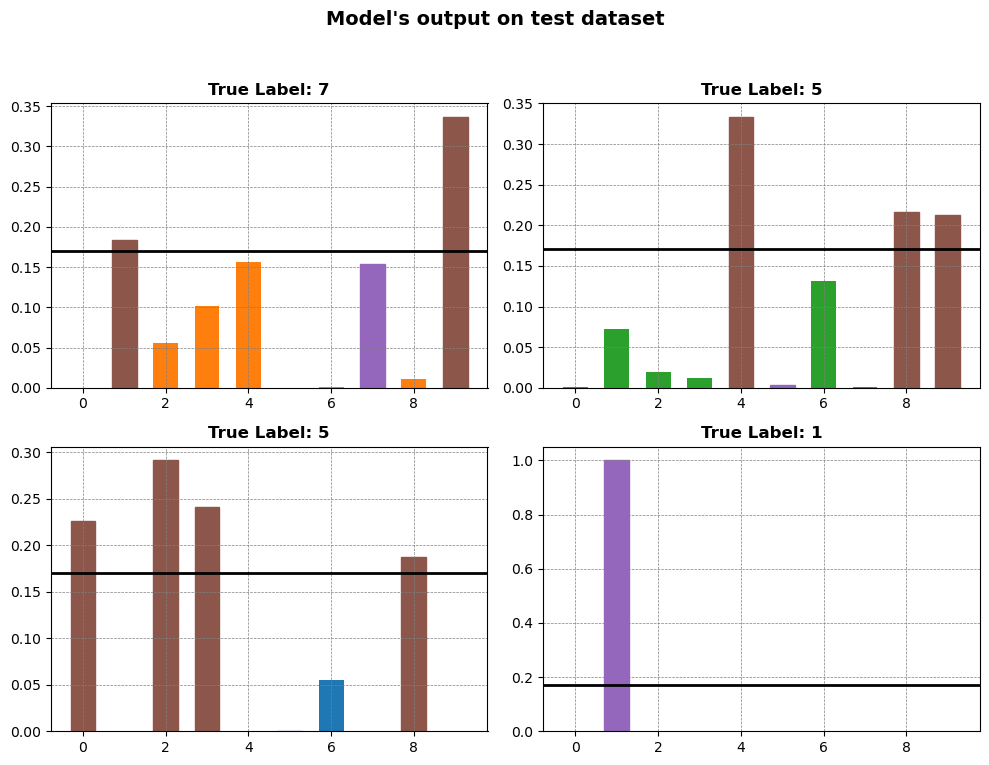

In [32]:
## Forming prediction sets

y1 = test_prediction_results[min_std_indices_test[1]]
y2 = test_prediction_results[min_std_indices_test[2]]
y3 = test_prediction_results[min_std_indices_test[3]]
y4 = test_prediction_results[4500]

test_array_indices = [
    min_std_indices_test[1],
    min_std_indices_test[2],
    min_std_indices_test[3],
    4500,
]

x = np.arange(10)

# Create a new figure with 3 subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Add bar plots to the subplots
bars1 = axs[0, 0].bar(x, y1, color="#ff7f0e", width=0.6)
axs[0, 0].set_title(
    f"True Label: {test_target_results[test_array_indices[0]]}",
    fontsize=12,
    fontweight="bold",
)
bars2 = axs[0, 1].bar(x, y2, color="#2ca02c", width=0.6)
axs[0, 1].set_title(
    f"True Label: {test_target_results[test_array_indices[1]]}",
    fontsize=12,
    fontweight="bold",
)
bars3 = axs[1, 0].bar(x, y3, color="#1f77b4", width=0.6)
axs[1, 0].set_title(
    f"True Label: {test_target_results[test_array_indices[2]]}",
    fontsize=12,
    fontweight="bold",
)
bars4 = axs[1, 1].bar(x, y4, color="#d62728", width=0.6)
axs[1, 1].set_title(
    f"True Label: {test_target_results[test_array_indices[3]]}",
    fontsize=12,
    fontweight="bold",
)

# Add labels and title to the figure
fig.suptitle("Model's output on test dataset", fontsize=14, fontweight="bold")

for ax in axs.flat:
    ax.grid(color="gray", linestyle="--", linewidth=0.5)

for ax in axs.flatten():
    ax.axhline(y=qhat_intuit, color="black", linewidth=2)

# Fine-tune the subplot layout
fig.tight_layout(rect=[0, 0.03, 1, 0.95])


bars1_idx = y1 > qhat_intuit
bars2_idx = y2 > qhat_intuit
bars3_idx = y3 > qhat_intuit
bars4_idx = y4 > qhat_intuit

for i in range(10):
    if bars1_idx[i]:
        bars1[i].set_color("#8c564b")
    if bars2_idx[i]:
        bars2[i].set_color("#8c564b")
    if bars3_idx[i]:
        bars3[i].set_color("#8c564b")
    if bars4_idx[i]:
        bars4[i].set_color("#8c564b")

bars1[test_target_results[test_array_indices[0]]].set_color("#9467bd")
bars2[test_target_results[test_array_indices[1]]].set_color("#9467bd")
bars3[test_target_results[test_array_indices[2]]].set_color("#9467bd")
bars4[test_target_results[test_array_indices[3]]].set_color("#9467bd")

_All the bars above the $\hat{q}_{intuit}$ are the part of the prediction set for the corresponding test dataset\_


In [33]:
# Use numpy indexing to get the softmax scores for each image corresponding to their true labels
test_true = test_prediction_results[
    np.arange(test_prediction_results.shape[0]), test_target_results
]

## *Implementing conformal prediction using the General Method*

_1. Here the heuristic notion of uncertainity is softmax output_


In [34]:
# Problem setup
n = 5000  # number of calibration points
alpha = 0.15  # 1-alpha is the desired coverage


In [35]:
cal_scores = 1 - calib_true


_2. Defining the score function as: $S(x,y)$ = $1- softmax(x_i,y_i)$_


In [36]:
q_level = np.ceil((n + 1) * (1 - alpha)) / n  ## alpha = 0.1, n = 1000, q_level = 0.901
qhat = np.quantile(
    cal_scores, q_level
)  ## value for which 90% of the scores are less than it
qhat

0.8337927011847496

_3. Calculating $\hat{q}$_


_4. Creating the prediction set_

$ C(x) = \{y:S(x,y) \le \hat{q} \}$


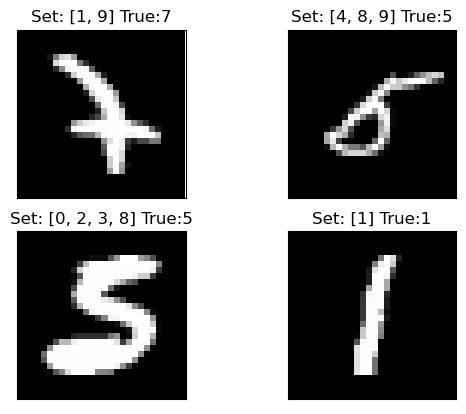

In [37]:
fig = plt.figure()
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow(test_images[test_array_indices[i]][0], cmap="gray", interpolation="none")
    test_scores = 1 - test_prediction_results[test_array_indices[i]]
    prediction_set = test_scores < qhat
    indices = []
    for index, val in enumerate(prediction_set):
        if val:
            indices.append(index)

    true_label = test_target_results[test_array_indices]

    plt.title(f"Set: {indices} True:{true_label[i]}")
    plt.xticks([])
    plt.yticks([])


## _Insights and Summary:_

1. Given an image $x$ and label $j$. Softmax measures $P(Y = j | X = x)$. However, we have no guarantee that the softmax outputs are any good; they maybe arbitrarily overfit or otherwise untrustworthy. Thus, we use the holdout set to adjust for their deficiencies.

2. In the above example the holdout set contained 5000 examples that the model never saw during training which gives us an honest appraisal of its performance.

3. Here, the conformal score was 1 - softmax output of the true class. Then we took $\hat{q} = 1 - \alpha $ quantile of the scores.

4. Using Step 3 at the test time, we got the softmax outputs of a new image $X_{test}$ and collected all classes with outputs above $ 1 − \hat{q}$ into a prediction set $C(X_{test})$


### *Implementation using Imagenet*

In [38]:
if not os.path.exists("../data"):
    os.system("gdown 1h7S6N_Rx7gdfO3ZunzErZy6H7620EbZK -O ../data.tar.gz")
    os.system("tar -xf ../data.tar.gz -C ../")
    os.system("rm ../data.tar.gz")
if not os.path.exists("../data/imagenet/human_readable_labels.json"):
    !wget -nv -O ../data/imagenet/human_readable_labels.json -L https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json

data = np.load("../data/imagenet/imagenet-resnet152.npz")
example_paths = os.listdir("../data/imagenet/examples")
smx = data["smx"]
labels = data["labels"].astype(int)

In [39]:
# Problem setup
n = 1000  # number of calibration points
alpha = 0.1  # 1-alpha is the desired coverage

In [40]:
idx = np.array([1] * n + [0] * (smx.shape[0] - n)) > 0
np.random.shuffle(idx)
cal_smx, val_smx = smx[idx, :], smx[~idx, :]
cal_labels, val_labels = labels[idx], labels[~idx]


In [41]:
imagenet_calib_df = pd.DataFrame(cal_smx)
imagenet_calib_df

0             1             2             3             4    \
0    9.646587e-01  1.350361e-05  2.151330e-07  1.699551e-06  2.384544e-06   
1    9.992527e-01  1.005275e-06  5.030975e-08  2.312540e-08  6.919812e-07   
2    9.998410e-01  2.081634e-08  2.163244e-09  1.033369e-08  9.947884e-09   
3    9.996231e-01  6.980400e-06  7.547856e-08  1.445374e-07  5.570853e-07   
4    3.740840e-07  9.997242e-01  6.791072e-10  4.707819e-09  3.942747e-09   
..            ...           ...           ...           ...           ...   
995  1.338609e-13  2.481204e-13  2.981873e-12  2.992094e-12  8.025680e-13   
996  1.461727e-05  2.962031e-05  2.201413e-07  3.813796e-08  1.196295e-07   
997  3.484188e-06  1.047919e-07  7.475886e-08  3.465406e-07  1.347377e-06   
998  7.082336e-04  2.196637e-05  1.516250e-05  7.714512e-04  1.190577e-01   
999  4.129702e-14  2.889617e-12  2.798768e-13  4.931771e-13  2.598153e-12   

              5             6             7             8             9    \
0    1.646308e-06  1.394906e-07  2.117511e-08  3.057390e-09  4.086660e-10   
1    5.068674e-08  5.945228e-08  2.580266e-09  1.059923e-09  5.929557e-11   
2    4.689700e-09  4.500399e-09  4.603104e-11  2.665861e-11  4.032333e-12   
3    1.413495e-06  1.172659e-07  4.219434e-09  9.644072e-10  4.150972e-11   
4    3.235905e-07  1.922253e-08  7.563041e-09  4.848560e-09  1.836324e-11   
..            ...           ...           ...           ...           ...   
995  1.196738e-12  1.058158e-12  1.031028e-14  8.366420e-14  1.834110e-16   
996  3.246882e-07  2.723306e-06  2.824044e-06  9.639041e-06  2.289236e-05   
997  4.767327e-06  4.182576e-08  4.709841e-08  1.508235e-08  1.065061e-08   
998  5.289520e-02  3.330159e-04  1.690781e-07  1.402206e-06  4.881958e-08   
999  9.916586e-14  3.006582e-13  8.608723e-12  2.060572e-12  5.938183e-13   

     ...           990           991           992           993  \
0    ...  5.279725e-09  9.462966e-08  1.185813e-08  5.307772e-10   
1    ...  3.178681e-10  3.120479e-09  2.160190e-09  6.229624e-10   
2    ...  1.170430e-10  1.740400e-10  1.001514e-10  2.484425e-11   
3    ...  1.467458e-09  1.727905e-08  4.188708e-08  8.764998e-10   
4    ...  1.428742e-09  2.168828e-09  7.591582e-10  7.432400e-11   
..   ...           ...           ...           ...           ...   
995  ...  2.835526e-10  1.185883e-09  5.707088e-11  1.053065e-10   
996  ...  2.566843e-02  1.156482e-01  1.163806e-03  6.741311e-03   
997  ...  2.632773e-06  2.174731e-05  3.774206e-04  1.449335e-04   
998  ...  1.218608e-05  2.880947e-03  5.116140e-04  1.090989e-01   
999  ...  1.010096e-11  1.221625e-11  2.120370e-11  2.549839e-13   

              994           995           996           997           998  \
0    2.161666e-07  1.007043e-08  9.514928e-08  8.144019e-07  1.339111e-07   
1    3.004631e-08  2.982520e-10  3.827619e-08  2.310420e-07  9.114003e-08   
2    6.860166e-10  5.098253e-11  9.393597e-10  3.404014e-08  1.460277e-09   
3    3.017675e-08  1.152834e-09  2.212167e-08  5.312061e-07  7.742039e-09   
4    8.145293e-10  6.436701e-10  6.601004e-10  2.608228e-10  1.372821e-09   
..            ...           ...           ...           ...           ...   
995  6.115803e-09  1.000000e+00  6.104551e-11  3.662891e-10  2.519912e-13   
996  1.174134e-03  1.015575e-03  4.271199e-01  3.027194e-01  3.415058e-04   
997  8.616778e-01  8.140442e-05  1.180090e-04  1.335993e-01  7.427732e-06   
998  8.638866e-03  3.532250e-02  1.301925e-02  5.380661e-01  1.777594e-05   
999  5.645862e-10  5.007978e-11  3.019627e-10  1.544346e-11  1.280130e-11   

              999  
0    6.878381e-09  
1    6.513726e-10  
2    8.657306e-13  
3    6.035842e-10  
4    1.686885e-07  
..            ...  
995  1.617798e-11  
996  8.422194e-07  
997  3.561391e-08  
998  4.036425e-07  
999  9.915479e-01  

[1000 rows x 1000 columns]

## _Adaptive Prediction Sets_

In comparison to the earlier method:

1. This method will have a larger predictive set size.
2. Much more adaptive ($i.e.$ Larger set size for hard examples and small set size for easy examples).
3. The earlier method used the softmax value corresponding to only the true class of the output.


### *Implementation*

In [42]:
if not os.path.exists("../data"):
    os.system("gdown 1h7S6N_Rx7gdfO3ZunzErZy6H7620EbZK -O ../data.tar.gz")
    os.system("tar -xf ../data.tar.gz -C ../")
    os.system("rm ../data.tar.gz")
if not os.path.exists("../data/imagenet/human_readable_labels.json"):
    !wget -nv -O ../data/imagenet/human_readable_labels.json -L https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json

data = np.load("../data/imagenet/imagenet-resnet152.npz")
example_paths = os.listdir("../data/imagenet/examples")
smx = data["smx"]
labels = data["labels"].astype(int)

In [43]:
# Problem setup
n = 1000  # number of calibration points
alpha = 0.1  # 1-alpha is the desired coverage

In [44]:
idx = np.array([1] * n + [0] * (smx.shape[0] - n)) > 0
np.random.shuffle(idx)
cal_smx, val_smx = smx[idx, :], smx[~idx, :]
cal_labels, val_labels = labels[idx], labels[~idx]


In [45]:
cal_pi = cal_smx.argsort(1)[
    :, ::-1
]  ## sorting the cal_smx in descending order and storing the indices in cal_pi
cal_srt = np.take_along_axis(cal_smx, cal_pi, axis=1).cumsum(
    axis=1
)  ##  take the elements of 'cal_smx' corresponding to the indices in 'cal_pi' and take the cumulative sum along each row
cal_scores = np.take_along_axis(cal_srt, cal_pi.argsort(axis=1), axis=1)[
    range(n), cal_labels
]  ##  take the elements of 'cal_srt' corresponding to the indices of the sorted 'cal_pi' and select the score corresponding to the 'cal_labels'

In [46]:
example = np.array(
    [
        [3, 4, 2, 1, 6],
        [5, 4, 6, 7, 3],
        [9, 5, 4, 3, 7],
        [5, 4, 3, 7, 8],
        [0, 3, 2, 1, 6],
    ]
)
example_labels = np.array([2, 3, 1, 4, 2])

example_pi = example.argsort(1)[:, ::-1]
print(example_pi)

example_srt = np.take_along_axis(example, example_pi, axis=1).cumsum(axis=1)
print(example_srt)

example_scores = np.take_along_axis(example_srt, example_pi.argsort(axis=1), axis=1)
print(example_scores)

example_scores[range(5), example_labels]

[[4 1 0 2 3]
 [3 2 0 1 4]
 [0 4 1 2 3]
 [4 3 0 1 2]
 [4 1 2 3 0]]
[[ 6 10 13 15 16]
 [ 7 13 18 22 25]
 [ 9 16 21 25 28]
 [ 8 15 20 24 27]
 [ 6  9 11 12 12]]
[[13 10 15 16  6]
 [18 22 13  7 25]
 [ 9 21 25 28 16]
 [20 24 27 15  8]
 [12  9 11 12  6]]


array([15,  7, 21,  8, 11])

In [47]:
# example = np.array([[3,4,2,1,6],[5,4,6,7,3],[9,5,4,3,7],[5,4,3,7,8],[0,3,2,1,6]])
# example_pi = example.sort()
# print(example_pi)

_1. The softmax output corresponding to an image is sorted in decreasing order. Then we consider the $E_i$ as the total mass of the softmax function for a particular label until we reach the true label._


In [48]:
# Get the score quantile
qhat = np.quantile(cal_scores, np.ceil((n + 1) * (1 - alpha)) / n)
qhat


0.9998794758319854

_2. Calculating the quantile value $\hat{q}$_


In [49]:
# Deploy (output=list of length n, each element is tensor of classes)
val_pi = val_smx.argsort(1)[:, ::-1]
val_srt = np.take_along_axis(val_smx, val_pi, axis=1).cumsum(axis=1)
prediction_sets = np.take_along_axis(val_srt <= qhat, val_pi.argsort(axis=1), axis=1)


In [50]:
eg = np.array([7, 5, 4, 3, 2, 1, 4, 3, 6, 7])
eg_pi = eg.argsort()[::-1]
eg_srt = np.take_along_axis(eg, eg_pi, axis=0).cumsum()
p_set = np.take_along_axis(eg_srt <= 0.8, eg_pi.argsort(), axis=0)


In [51]:
img = smx[1][0:10]
img_pi = img.argsort()[::-1]
img_srt = np.take_along_axis(img, img_pi, axis=0).cumsum()
prediction_set = np.take_along_axis(img_srt <= qhat, img_pi.argsort(), axis=0)
print(img_pi, img, img_srt, prediction_set)


[0 1 4 3 5 2 6 7 8 9] [9.64658678e-01 1.35036071e-05 2.15132957e-07 1.69955081e-06
 2.38454436e-06 1.64630808e-06 1.39490609e-07 2.11751061e-08
 3.05739034e-09 4.08666018e-10] [0.96465868 0.96467218 0.96467457 0.96467627 0.96467791 0.96467813
 0.96467827 0.96467829 0.96467829 0.96467829] [ True  True  True  True  True  True  True  True  True  True]


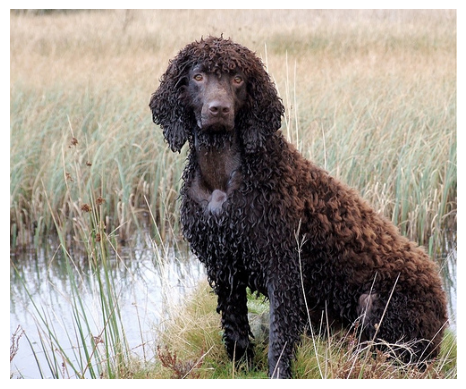

The prediction set is: ['prairie grouse', 'partridge', 'Afghan Hound', 'Otterhound', 'Bedlington Terrier', 'Kerry Blue Terrier', 'Giant Schnauzer', 'Flat-Coated Retriever', 'Curly-coated Retriever', 'Chesapeake Bay Retriever', 'German Shorthaired Pointer', 'Vizsla', 'Irish Setter', 'Gordon Setter', 'Brittany', 'Clumber Spaniel', 'English Springer Spaniel', 'Welsh Springer Spaniel', 'Cocker Spaniels', 'Sussex Spaniel', 'Irish Water Spaniel', 'Australian Kelpie', 'Komondor', 'Newfoundland', 'Toy Poodle', 'Miniature Poodle', 'Standard Poodle', 'hyena', 'leopard', 'cheetah', 'brown bear', 'American black bear', 'mongoose', 'wild boar', 'bison', 'ram', 'llama', 'weasel', 'mink', 'guenon', 'baboon', 'honeycomb', 'jeep', 'wig', 'acorn', 'gyromitra']


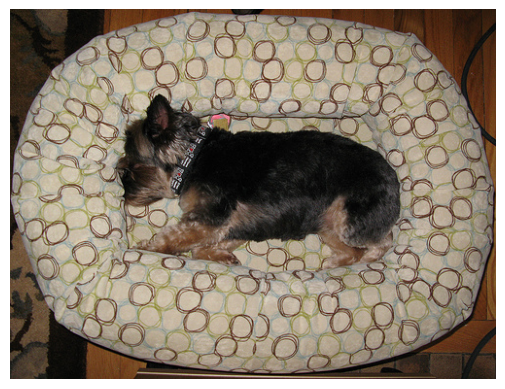

The prediction set is: ['Otterhound', 'Border Terrier', 'Norfolk Terrier', 'Norwich Terrier', 'Yorkshire Terrier', 'Wire Fox Terrier', 'Lakeland Terrier', 'Airedale Terrier', 'Cairn Terrier', 'Australian Terrier', 'Dandie Dinmont Terrier', 'Miniature Schnauzer', 'Standard Schnauzer', 'Scottish Terrier', 'Australian Silky Terrier', 'German Shepherd Dog']


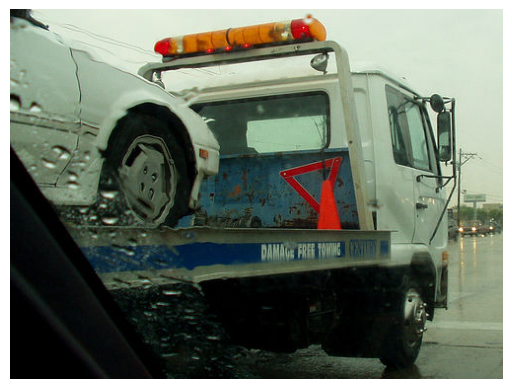

The prediction set is: ['goldfish', 'tiger shark', 'cock', 'house finch', 'agama', 'triceratops', 'ring-necked snake', 'sea snake', 'southern black widow', 'centipede', 'black grouse', 'prairie grouse', 'grey parrot', 'macaw', 'lorikeet', 'hornbill', 'hummingbird', 'toucan', 'flatworm', 'nematode', 'sea slug', 'fiddler crab', 'American lobster', 'spiny lobster', 'crayfish', 'hermit crab', 'isopod', 'crane (bird)', 'oystercatcher', 'Bloodhound', 'Miniature Schnauzer', 'Giant Schnauzer', 'Standard Schnauzer', 'Labrador Retriever', 'English Setter', 'Gordon Setter', 'Brittany', 'Cocker Spaniels', 'Sussex Spaniel', 'Rottweiler', 'Greater Swiss Mountain Dog', 'Dalmatian', 'cougar', 'tiger', 'polar bear', 'mongoose', 'ladybug', 'stick insect', 'cockroach', 'leafhopper', 'damselfly', 'red admiral', 'gossamer-winged butterfly', 'sea cucumber', 'hamster', 'beaver', 'guinea pig', 'pig', 'weasel', 'mink', 'European polecat', 'black-footed ferret', 'skunk', 'badger', 'macaque', 'marmoset', 'red pa

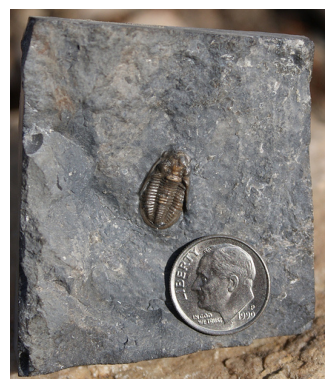

The prediction set is: ['alligator lizard', 'trilobite', 'scorpion', 'tick', 'centipede', 'conch', 'snail', 'chiton', 'crayfish', 'hermit crab', 'isopod', 'ground beetle', 'weevil', 'cockroach', 'cicada', 'sea cucumber', 'armadillo', 'corn']


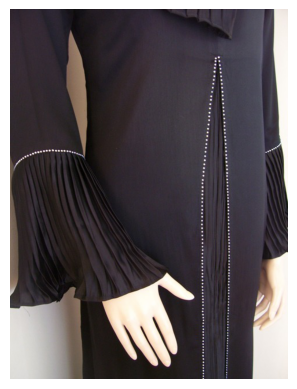

The prediction set is: ['tench', 'great white shark', 'tiger shark', 'hammerhead shark', 'electric ray', 'stingray', 'cock', 'hen', 'house finch', 'junco', 'indigo bunting', 'vulture', 'spotted salamander', 'loggerhead sea turtle', 'leatherback sea turtle', 'green iguana', 'desert grassland whiptail lizard', 'frilled-necked lizard', 'Gila monster', 'European green lizard', 'triceratops', 'eastern hog-nosed snake', 'kingsnake', 'vine snake', 'night snake', 'boa constrictor', 'harvestman', 'scorpion', 'yellow garden spider', 'barn spider', 'European garden spider', 'southern black widow', 'tarantula', 'tick', 'centipede', 'black grouse', 'ruffed grouse', 'prairie grouse', 'partridge', 'grey parrot', 'macaw', 'sulphur-crested cockatoo', 'coucal', 'hornbill', 'toucan', 'tusker', 'echidna', 'wombat', 'jellyfish', 'sea anemone', 'flatworm', 'conch', 'slug', 'chambered nautilus', 'Dungeness crab', 'rock crab', 'red king crab', 'American lobster', 'spiny lobster', 'crayfish', 'hermit crab', 'i

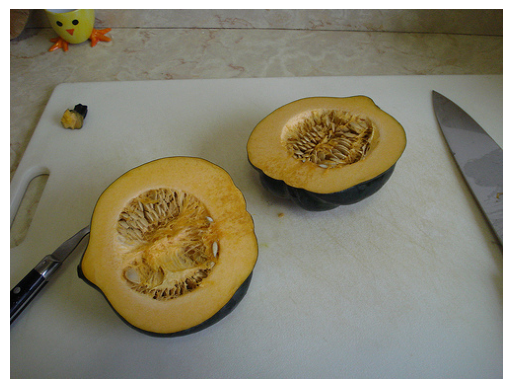

The prediction set is: []


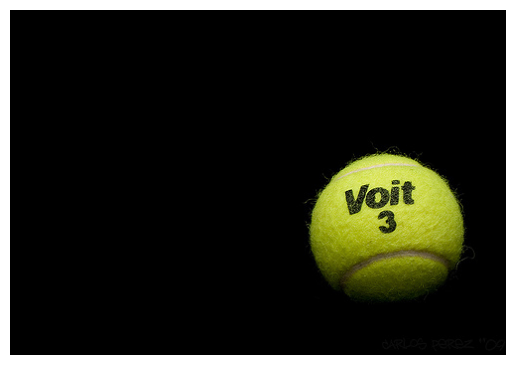

The prediction set is: ['tennis ball']


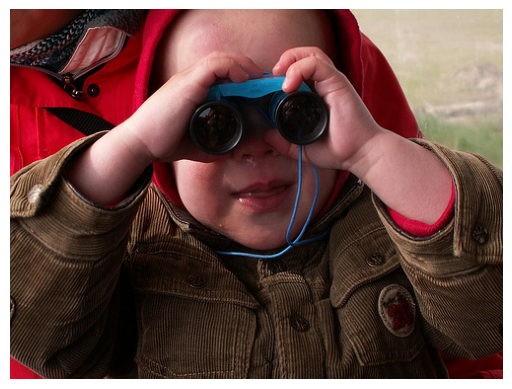

The prediction set is: []


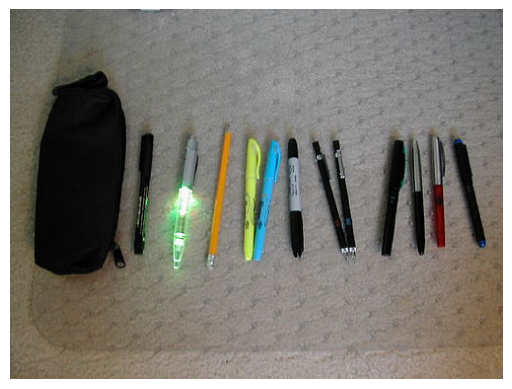

The prediction set is: ['jay', 'tick', 'grey parrot', 'macaw', 'slug', 'common gallinule', 'Pekingese', 'Shih Tzu', 'Papillon', 'West Highland White Terrier', 'Shetland Sheepdog', 'collie', 'rhinoceros beetle', 'dragonfly', 'damselfly', 'sea urchin', 'accordion', 'analog clock', 'backpack', 'ballpoint pen', 'Band-Aid', 'bassoon', 'beaker', 'bib', 'ring binder', 'bolo tie', 'bookcase', 'bookstore', 'bow', 'bow tie', 'broom', 'bucket', 'buckle', 'cauldron', 'candle', 'can opener', 'tool kit', 'carton', 'cassette', 'cassette player', 'CD player', 'mobile phone', 'chain', 'chime', 'Christmas stocking', 'cloak', 'coffee mug', 'coil', 'computer keyboard', 'croquet ball', 'crutch', 'desk', 'digital clock', 'digital watch', 'dishcloth', 'drum', 'drumstick', 'electric guitar', 'envelope', 'face powder', 'feather boa', 'filing cabinet', 'flute', 'fountain pen', 'grand piano', 'barrette', 'hair spray', 'hammer', 'hand-held computer', 'handkerchief', 'hard disk drive', 'harmonica', 'hook', 'iPod',

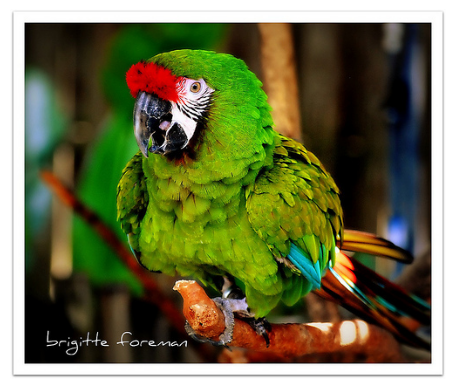

The prediction set is: ['grey parrot', 'macaw', 'lorikeet']


In [52]:
with open("../data/imagenet/human_readable_labels.json") as f:
    label_strings = np.array(json.load(f))

example_paths = os.listdir("../data/imagenet/examples")
for i in range(10):
    rand_path = np.random.choice(example_paths)
    img = imread("../data/imagenet/examples/" + rand_path)
    img_index = int(rand_path.split(".")[0])
    img_pi = smx[img_index].argsort()[::-1]
    img_srt = np.take_along_axis(smx[img_index], img_pi, axis=0).cumsum()
    prediction_set = np.take_along_axis(img_srt <= qhat, img_pi.argsort(), axis=0)
    plt.figure()
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    print(f"The prediction set is: {list(label_strings[prediction_set])}")